In [1]:
import pandas as pd
import numpy as np

In [2]:
# 당뇨병 데이터 불러오기
df = pd.read_csv('diabetes_data.csv')

In [3]:
# feature와 target 분리
target = df[['Diabetes']]
data = df.drop(columns=['Diabetes'])

In [4]:
# train_test 분리
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=33)

In [5]:
# Pipeline 을 위한 전처리 모듈 불러오기
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [6]:
x_train.head(3)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP
50498,13.0,0.0,1.0,1.0,32.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0
44300,10.0,0.0,1.0,1.0,22.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,10.0,20.0,0.0,0.0,1.0
49497,8.0,1.0,1.0,1.0,35.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0


In [7]:
# 파이프라인
# 수로 된 열 선택
numeric_features = ['Age', 'BMI', 'MentHlth', 'PhysHlth']
numeric_transformer = StandardScaler()

# 수로 된 열 제외한 모든 라벨로 된 열 선택
categorical_features = list(x_train.columns)
categorical_features.remove('Age')
categorical_features.remove('BMI')
categorical_features.remove('MentHlth')
categorical_features.remove('PhysHlth')

categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore') 

# 전처리 모델 생성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [8]:
# 파이프라인으로 전처리
preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

In [9]:
# 파이프라인 학습
preprocessor_pipe.fit(x_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'BMI', 'MentHlth',
                                                   'PhysHlth']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'GenHlth', 'DiffWalk',
                                                   'Stroke', 'HighBP'])]))])

In [10]:
# 파이프라인 학습된 전처리로 변환
x_train = preprocessor_pipe.transform(x_train)
x_test = preprocessor_pipe.transform(x_test)

In [11]:
# 딥러닝 모듈 불러오기
import tensorflow as tf
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics
import keras_tuner as kt

In [12]:
# target 데이터 원핫인코딩
y_train = utils.to_categorical(y_train)

In [13]:
x_train.shape

(56553, 33)

In [14]:
# 순차적 모델 생성
model = models.Sequential()

# 열 31개
model.add(layers.Dense(input_dim=33, units=256, activation=None, kernel_initializer=initializers.he_normal()))
model.add(layers.BatchNormalization())
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_normal())) 
model.add(layers.Activation('elu')) 

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_normal())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_normal())) 
model.add(layers.Activation('elu')) 
model.add(layers.Dropout(rate=0.5))

# 이진분류 도출
model.add(layers.Dense(units=2, activation='softmax'))

In [15]:
# 모델 컴파일
model.compile(optimizer=optimizers.Adam(0.01),
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [16]:
# 콜백함수 적용
# 저장할 경로 지정
checkpoint_path = 'saved_models/diabetes_5layers_elu.h5'

# 콜백 객체 생성
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         monitor='val_loss', # default
                                                         save_best_only=True, # "Save" the "best" model "only"
                                                         verbose=0)

In [17]:
# 모델 학습
history = model.fit(x_train, y_train, batch_size=7200, epochs=200, validation_split=0.3, callbacks=[callback_checkpoint])

Epoch 1/200
6/6 [==============================] - 2s 216ms/step - loss: 10.9101 - categorical_accuracy: 0.5492 - val_loss: 1.4992 - val_categorical_accuracy: 0.3870
Epoch 2/200
6/6 [==============================] - 1s 190ms/step - loss: 1.0856 - categorical_accuracy: 0.5869 - val_loss: 0.5897 - val_categorical_accuracy: 0.6897
Epoch 3/200
6/6 [==============================] - 1s 186ms/step - loss: 0.6857 - categorical_accuracy: 0.6499 - val_loss: 0.5844 - val_categorical_accuracy: 0.6894
Epoch 4/200
6/6 [==============================] - 1s 188ms/step - loss: 0.6345 - categorical_accuracy: 0.6613 - val_loss: 0.5660 - val_categorical_accuracy: 0.7140
Epoch 5/200
6/6 [==============================] - 1s 187ms/step - loss: 0.6151 - categorical_accuracy: 0.6777 - val_loss: 0.5586 - val_categorical_accuracy: 0.7154
Epoch 6/200
6/6 [==============================] - 1s 187ms/step - loss: 0.5988 - categorical_accuracy: 0.6876 - val_loss: 0.5475 - val_categorical_accuracy: 0.7226
Epoch 7/2

6/6 [==============================] - 1s 196ms/step - loss: 0.5036 - categorical_accuracy: 0.7566 - val_loss: 0.5132 - val_categorical_accuracy: 0.7453
Epoch 51/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5027 - categorical_accuracy: 0.7559 - val_loss: 0.5077 - val_categorical_accuracy: 0.7499
Epoch 52/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5029 - categorical_accuracy: 0.7551 - val_loss: 0.5135 - val_categorical_accuracy: 0.7463
Epoch 53/200
6/6 [==============================] - 1s 190ms/step - loss: 0.5029 - categorical_accuracy: 0.7554 - val_loss: 0.5104 - val_categorical_accuracy: 0.7473
Epoch 54/200
6/6 [==============================] - 1s 196ms/step - loss: 0.5016 - categorical_accuracy: 0.7556 - val_loss: 0.5105 - val_categorical_accuracy: 0.7477
Epoch 55/200
6/6 [==============================] - 1s 197ms/step - loss: 0.5046 - categorical_accuracy: 0.7547 - val_loss: 0.5158 - val_categorical_accuracy: 0.7440
Epoch 56/200
6/6 

6/6 [==============================] - 1s 193ms/step - loss: 0.4823 - categorical_accuracy: 0.7679 - val_loss: 0.5338 - val_categorical_accuracy: 0.7364
Epoch 100/200
6/6 [==============================] - 1s 196ms/step - loss: 0.4832 - categorical_accuracy: 0.7663 - val_loss: 0.5188 - val_categorical_accuracy: 0.7440
Epoch 101/200
6/6 [==============================] - 1s 203ms/step - loss: 0.4803 - categorical_accuracy: 0.7692 - val_loss: 0.5200 - val_categorical_accuracy: 0.7416
Epoch 102/200
6/6 [==============================] - 1s 200ms/step - loss: 0.4784 - categorical_accuracy: 0.7709 - val_loss: 0.5347 - val_categorical_accuracy: 0.7329
Epoch 103/200
6/6 [==============================] - 1s 200ms/step - loss: 0.4780 - categorical_accuracy: 0.7694 - val_loss: 0.5344 - val_categorical_accuracy: 0.7431
Epoch 104/200
6/6 [==============================] - 1s 199ms/step - loss: 0.4803 - categorical_accuracy: 0.7714 - val_loss: 0.5261 - val_categorical_accuracy: 0.7402
Epoch 105/20

6/6 [==============================] - 1s 200ms/step - loss: 0.4357 - categorical_accuracy: 0.7930 - val_loss: 0.5802 - val_categorical_accuracy: 0.7313
Epoch 149/200
6/6 [==============================] - 1s 200ms/step - loss: 0.4394 - categorical_accuracy: 0.7911 - val_loss: 0.5935 - val_categorical_accuracy: 0.7239
Epoch 150/200
6/6 [==============================] - 1s 197ms/step - loss: 0.4525 - categorical_accuracy: 0.7870 - val_loss: 0.5943 - val_categorical_accuracy: 0.7287
Epoch 151/200
6/6 [==============================] - 1s 199ms/step - loss: 0.4539 - categorical_accuracy: 0.7843 - val_loss: 0.5667 - val_categorical_accuracy: 0.7318
Epoch 152/200
6/6 [==============================] - 1s 208ms/step - loss: 0.4304 - categorical_accuracy: 0.7984 - val_loss: 0.5894 - val_categorical_accuracy: 0.7323
Epoch 153/200
6/6 [==============================] - 1s 221ms/step - loss: 0.4281 - categorical_accuracy: 0.7985 - val_loss: 0.5888 - val_categorical_accuracy: 0.7311
Epoch 154/20

6/6 [==============================] - 1s 242ms/step - loss: 0.3939 - categorical_accuracy: 0.8174 - val_loss: 0.6527 - val_categorical_accuracy: 0.7233
Epoch 198/200
6/6 [==============================] - 1s 247ms/step - loss: 0.3944 - categorical_accuracy: 0.8159 - val_loss: 0.7013 - val_categorical_accuracy: 0.7221
Epoch 199/200
6/6 [==============================] - 1s 241ms/step - loss: 0.3745 - categorical_accuracy: 0.8252 - val_loss: 0.6939 - val_categorical_accuracy: 0.7128
Epoch 200/200
6/6 [==============================] - 1s 248ms/step - loss: 0.3667 - categorical_accuracy: 0.8301 - val_loss: 0.7499 - val_categorical_accuracy: 0.7247


In [18]:
# 시각화 모듈 불러오기
import matplotlib.pyplot as plt

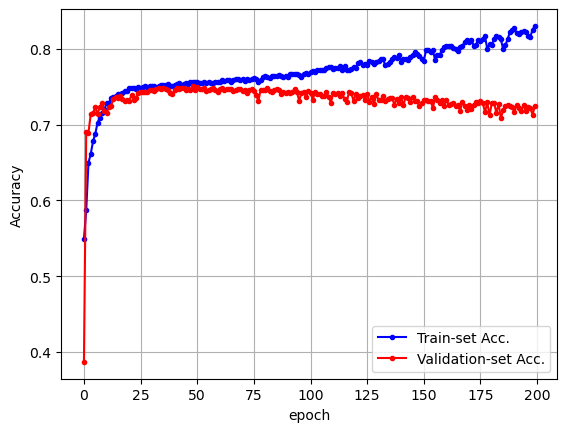

In [19]:
# train, validtion 정확도 시각화
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='lower right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

In [20]:
# 평가 모듈 불러오기
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [21]:
# 콜백 저장 모델 불러오기
model = models.load_model('saved_models/diabetes_5layers_elu.h5')

In [22]:
# test 예측
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

In [23]:
# 모델 평가
acc = accuracy_score(y_test, y_pred)
prs = precision_score(y_test, y_pred)
rc = recall_score(y_test, y_pred)
print('accuracy_score : ', acc)
print('precision_score : ', prs)
print('recall_score : ', rc)

accuracy_score :  0.7523162882806422
precision_score :  0.714356252314529
recall_score :  0.8296774193548387
